In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as pylab

In [2]:
from skimage import io
from skimage import color

def read_image(filename):
    image = io.imread(filename)
    return color.rgb2gray(image)

In [4]:
from skimage.feature import canny
from skimage.filters import sobel

def apply_canny(image):
    canny_img = canny(image, 6)
    return sobel(canny_img)

In [34]:
from skimage.transform import hough_line, hough_line_peaks

def get_hough_lines(canny_img):
    h, theta, d = hough_line(canny_img)
    lines = list()
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        print(np.degrees(angle), dist)
        x1 = 0
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        x2 = canny_img.shape[1]
        y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
        lines.append({
            'dist': dist,
            'angle': np.degrees(angle),
            'point1': [x1, y1],
            'point2': [x2, y2]
        })
    
    return lines

In [ ]:
def shortlist_lines(lines):
    MIN_ANGLE = 

In [32]:
def display_image(filename):
    image = read_image(filename)
    canny_image = apply_canny(image)
    lines = get_hough_lines(canny_image)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))
    plt.xlim(0,image.shape[1])
    plt.ylim(image.shape[0])
    
    ax1.set_title('Original Image')
    ax1.imshow(image, cmap=pylab.cm.gray)
    ax1.axis('on') 
    
    ax2.set_title('Hough Lines on Canny Edge Image')
    ax2.imshow(canny_image, cmap=pylab.cm.gray)
    ax2.axis('on')
    for line in lines:
        ax2.plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
    pylab.show()

/home/gsunit/my-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  


90.0 2.5031605562578534
-27.653631284916205 112.6422250316055
14.581005586592168 51.565107458912735
28.659217877094957 234.7964601769911
78.93854748603351 328.91529709228814
56.815642458100555 306.88748419721867


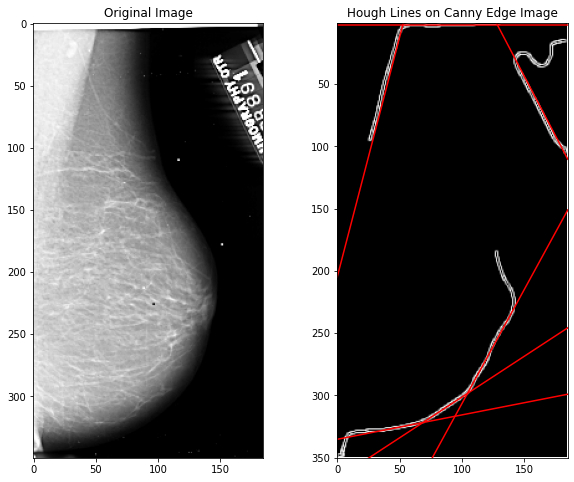

In [33]:
display_image('mammo_1.png')